This notebook stores less than successfull approaches

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
pd.options.display.max_columns = 150

In [2]:
# functions used throughout notebook
def load_data(filename, prefix):
    """Combine all three years of data for a file. Places prefix for each column"""
    years = ['s2014','s2015','s2016']
    mid_path = '/data/'
     
    for year in years:        
        path = year + mid_path + filename + '.csv'
        df = pd.read_csv(path,parse_dates = ['Date'], infer_datetime_format=True, index_col = 0, encoding='latin1')
        if year == 's2014':
            df_m = df
        else:
            df_m = df_m.append(df)
    
    df_m.columns = prefix + "__" + np.array(df_m.columns)
    df_m.reset_index(drop = True, inplace = True)
    
    # drop all % signs from dataframe
    for col in [col for col in df_m.columns if col.endswith('%')]:
        df_m[col] = df_m[col].str.replace("%","").astype(float)
    for col in [col for col in df_m.columns if col.endswith('HR/FB')]:
        df_m[col] = df_m[col].str.replace("%","").astype(float)
    
    # drop fake index col
    cols = [col for col in df_m.columns if not col.endswith("#")]
    df_m = df_m[cols]
    
    cols = [prefix + "__" + x for x in ['Date','Team','Name']]
    cols = [col for col in df_m.columns if col in cols]
    df_m.drop_duplicates(subset = cols, inplace = True)
    return df_m

def target_percent(df):
    """Calculate percent of set that results in ten selections per day
    
    Args:
        df: Full set dataframe
        
    Returns:
        Threshold value to be passed to np.percentile
    """
    game_count = df.date.unique().shape[0]
    at_bats = df.shape[0]
    pct = 10 / (at_bats / game_count)
    
    return 100 - round(pct * 100, 2)

def load_analysis_set(version):
    """Load analysis data set. Processes if necessary.
    Args:
        version: int. checkpointed version of data
        
    Returns:
        df: Analysis dataframe
    """ 
    file = 'data/analysis_' + str(version) + "_.csv"
    
    df = pd.read_csv(file, parse_dates=['date', 'date_m1'], encoding = 'latin1')
    
    return df

def random_predictions(df):
    """Returns array of random ones and zeros consistent with hit rate"""
    rate = df[df.model_set == 'train'].got_hit.mean()
    dev_size = (df.model_set == 'dev').sum()
    t = [1] * int(dev_size * rate)
    t += ([0] * (dev_size - len(t)))
    t = shuffle(np.array(t))
    return t

def rate_histogram(df, features):
    """Plot precision by percentile for a set of features in facetgrid
    
    Args:
        df: model dataframe. must have features and model_set column
        features: names of columns to plot
    """
    # get percentile groupings of train set for selected features
    df = df[df.model_set == 'train']
    df_long = pd.DataFrame(columns=['percentile', 'feature', 'got_hit'])
    labels = [x for x in range(1,11)]
    for feature in features:
        bins = pd.cut(df[feature], bins=10, labels=labels)
        df_temp = pd.DataFrame({'percentile': bins, 
                                'feature': [feature] * len(bins), 
                                'got_hit': df.got_hit.tolist()})
        df_long = pd.concat([df_long, df_temp])
    
    # get average hit rate
    df_long['got_hit'] = pd.to_numeric(df_long.got_hit)
    df_long['percentile'] = pd.to_numeric(df_long.percentile)
    df_long = df_long.groupby(['feature', 'percentile']).mean().reset_index()
    
    # plot as facet grid
    g = sns.FacetGrid(df_long, col="feature", col_wrap=3)
    g = g.map(plt.plot, "percentile", "got_hit", marker = ".")

not_features = ['date','home','matchup','opp_pitcher','opp_pitcher_lefty',
                'opp_team','own_pitcher','own_pitcher_lefty','team', 'date_m1',
                'team_fg','opp_team_fg','got_hit','name','model_set','fs_id']

## Recent Batting Performance

In [3]:
# load and merge data
df = load_analysis_set(2)
temp_df = load_data('hitting/week_master','p7')
col_match ={'p7__Name': 'name', 'p7__Date': 'date_m1', 'p7__Team': 'team_fg'}
temp_df.rename(columns=col_match, 
               inplace = True)
df = pd.merge(df, temp_df, how = 'left', on = list(col_match.values()))
df.drop('p7__Season', axis = 1, inplace = True)

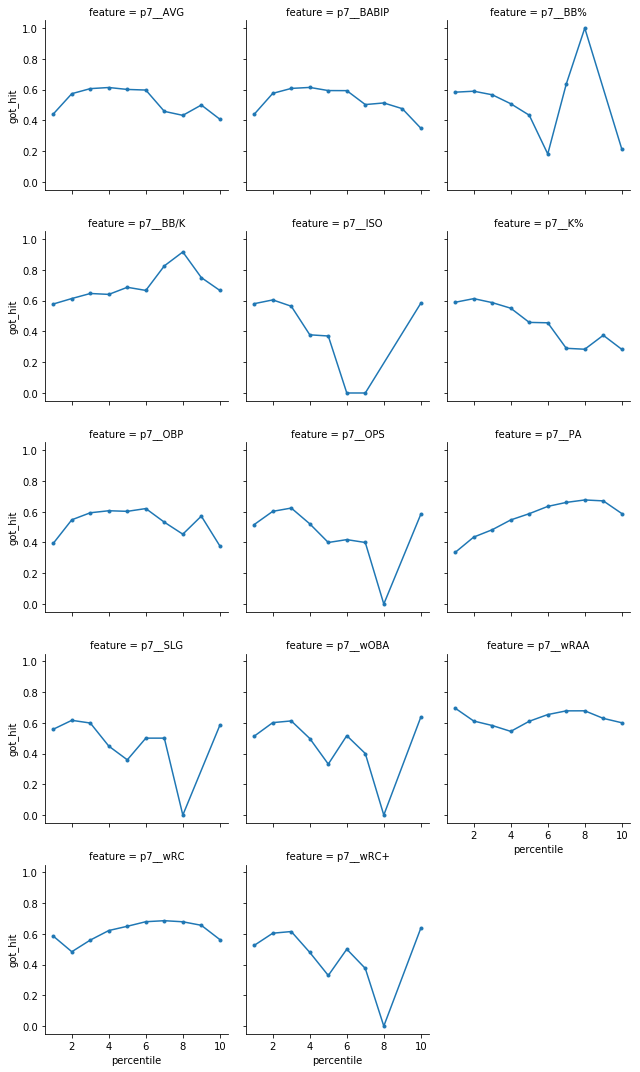

In [4]:
cols = [x for x in df.columns if x.startswith('p7')]
rate_histogram(df, cols)

cols = [x for x in df.columns if not x.startswith('p7')]
cols += ['p7__BB%', 'p7__BB/K', 'p7__ISO', 'p7__K%', 'p7__PA', 'p7__wRC']
df = df[cols]
df.fillna(-1, inplace = True)

In [5]:
features = [x for x in df.columns if x not in not_features]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=75, max_features=None)
m = df.model_set == 'train'
rfc.fit(df.loc[m,features], df[m]['got_hit'])
m = df.model_set == 'dev'
dev_probs = rfc.predict_proba(df.loc[m,features])[:,1]

In [6]:
thresh = np.percentile(dev_probs, 50)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.493     0.588     0.536     21450
       True      0.654     0.564     0.606     29698

avg / total      0.587     0.574     0.577     51148



In [7]:
list(zip(features, rfc.feature_importances_))

[('hitbin_g_cum', 0.13904938061142824),
 ('hitbin_avg_cum', 0.30236287194132433),
 ('hitbin_avg_p7', 0.032344454208146189),
 ('hitbin_avg_p21', 0.05177852606985299),
 ('p7__BB%', 0.07236029951766644),
 ('p7__BB/K', 0.031146812233516563),
 ('p7__ISO', 0.10136977442478083),
 ('p7__K%', 0.10412565320375827),
 ('p7__PA', 0.11963349218809763),
 ('p7__wRC', 0.045828735601428701)]